In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
nn_res_path = "AI_all.csv"
heuristic_res_path = "ExecutionTreeContributedCoverage_all.csv"

In [3]:
heu_df = pd.read_csv(nn_res_path)
nn_df = pd.read_csv(heuristic_res_path)

In [4]:
set(pd.read_csv(nn_res_path)["method"]).symmetric_difference(
    set(pd.read_csv(heuristic_res_path)["method"])
)

{'Collections.Viewable.ReactiveEx.AddLifetimed',
 'CommentHelpInfo.GetCommentBlock',
 'Sid.Flush',
 'System.Management.Automation.ProxyCommand.GetHelpComments'}

In [5]:
def drop_failed(df: pd.DataFrame) -> int:
    failed = df[(df["coverage"] == -1)].index
    return failed


heu_df = heu_df.drop(drop_failed(heu_df))
nn_df = nn_df.drop(drop_failed(nn_df))

In [6]:
heu_df.describe()

,tests,errors,coverage,total_time_sec
count,202.000000,202.000000,202.000000,202.000000
mean,3.425743,8.613861,79.643564,40.683168
std,6.443550,38.794001,29.349357,49.865377
min,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,63.250000,0.000000
50%,2.000000,2.000000,100.000000,1.000000
75%,3.750000,4.750000,100.000000,96.000000
max,59.000000,487.000000,100.000000,125.000000


In [7]:
nn_df.describe()

,tests,errors,coverage,total_time_sec
count,195.000000,195.000000,195.000000,195.000000
mean,4.507692,12.282051,84.912821,26.800000
std,8.430657,44.481983,26.308001,45.380136
min,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,76.000000,0.000000
50%,2.000000,3.000000,100.000000,0.000000
75%,4.000000,7.000000,100.000000,27.500000
max,77.000000,519.000000,100.000000,151.000000


In [8]:
nn_df.head()

,method,tests,errors,coverage,total_time_sec,timeouted
0,BinarySearch,7,1,100.0,0,False
1,Switches1,30,0,100.0,3,False
2,Switches2,12,0,100.0,97,False
3,Switches3,24,3,94.0,120,True
4,Switches4,12,3,100.0,0,False


In [9]:
heu_df.head()

,method,tests,errors,coverage,total_time_sec,timeouted
0,BinarySearch,7,0,100.0,0,False
1,Switches1,31,0,100.0,31,False
2,Switches2,10,0,100.0,104,False
3,Switches3,2,3,41.0,96,False
4,Switches4,10,3,100.0,96,False


In [10]:
inner_df = heu_df.merge(nn_df, on="method", how="inner", suffixes=("V#", "AI"))
inner_df

,method,testsV#,errorsV#,coverageV#,total_time_secV#,timeoutedV#,testsAI,errorsAI,coverageAI,total_time_secAI,timeoutedAI
0,BinarySearch,7,0,100.0,0,False,7,1,100.0,0,False
1,Switches1,31,0,100.0,31,False,30,0,100.0,3,False
2,Switches2,10,0,100.0,104,False,12,0,100.0,97,False
3,Switches3,2,3,41.0,96,False,24,3,94.0,120,True
4,Switches4,10,3,100.0,96,False,12,3,100.0,0,False
...,...,...,...,...,...,...,...,...,...,...,...
185,PartialDerivUtilWriter.GenerateDefinitionsAndF...,1,5,3.0,120,True,3,5,0.0,96,False
186,HlslGenerator.MarkApdNodesAndVariablesIsLegal,5,12,58.0,96,False,16,12,75.0,120,True
187,HlslGenerator.CalculateApdDependenciesRecurse,6,6,15.0,120,True,22,140,42.0,120,True
188,Collections.ConcurrentMask.AtomicAnd,1,0,100.0,0,False,1,0,100.0,0,False


In [11]:
def cutoff_by_quantile(df: pd.Series, lower: float = None, upper: float = None):
    lower_df, upper_df = None, None
    if lower is not None:
        lower_df = df[df <= df.quantile(lower, method="table", interpolation="nearest")]
        df = df[df > df.quantile(lower, method="table", interpolation="nearest")]

    if upper is not None:
        upper_df = df[df >= df.quantile(upper, method="table", interpolation="nearest")]
        df = df[df < df.quantile(upper, method="table", interpolation="nearest")]

    return lower_df, df, upper_df

In [12]:
def compare(
    dataframe: pd.DataFrame,
    on: str,
    desc: str,
    metric: str,
    divider_line: bool = False,
    reverse_colors: bool = False,
    logscale: bool = False,
):
    AI_more = dataframe.loc[dataframe[f"{on}V#"] < dataframe[f"{on}AI"]]
    VSharp_more = dataframe.loc[dataframe[f"{on}V#"] > dataframe[f"{on}AI"]]
    eq = dataframe.loc[dataframe[f"{on}V#"] == dataframe[f"{on}AI"]]

    len(AI_more)
    len(VSharp_more)
    len(eq)
    print(f"{len(AI_more)=}, {len(VSharp_more)=}, {len(eq)=}")
    if logscale:
        plt.xscale("log")
        plt.yscale("log")
        desc += ", logscale"

    if divider_line:
        plt.axline([0, 0], [1, 1])

    colors = ["green", "red", "black"]
    if reverse_colors:
        colors = ["red", "green", "black"]
    plt.scatter(AI_more[f"{on}V#"], AI_more[f"{on}AI"], color=colors[0])
    plt.scatter(VSharp_more[f"{on}V#"], VSharp_more[f"{on}AI"], color=colors[1])
    plt.scatter(eq[f"{on}V#"], eq[f"{on}AI"], color=colors[2])
    plt.xlabel(f"V# {on}, {metric}\n\n{on} comparison on the same methods\n{desc}")
    plt.ylabel(f"AI {on}, {metric}")
    plt.show()

len(AI_more)=46, len(VSharp_more)=12, len(eq)=132


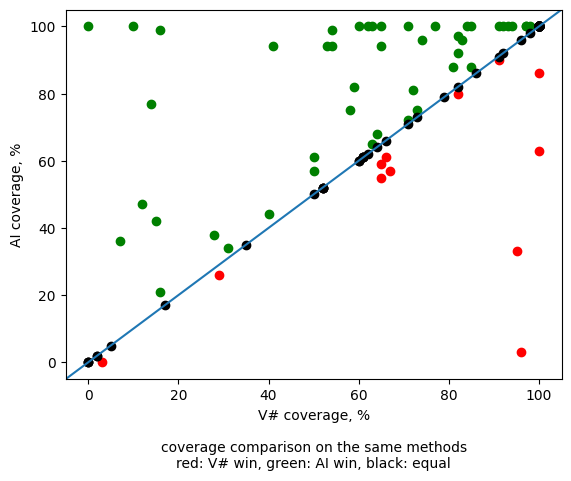

len(AI_more)=56, len(VSharp_more)=17, len(eq)=117


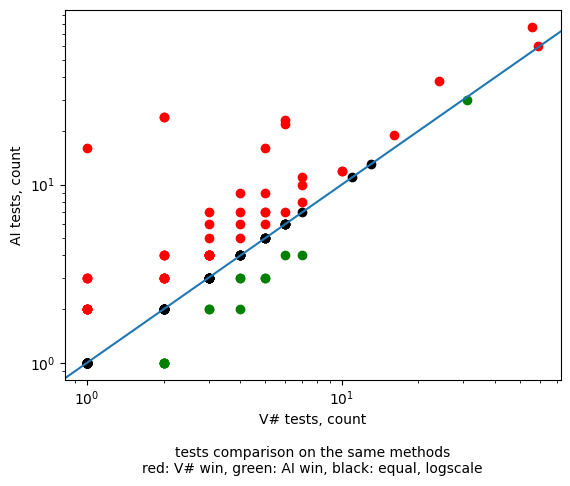

len(AI_more)=67, len(VSharp_more)=13, len(eq)=110


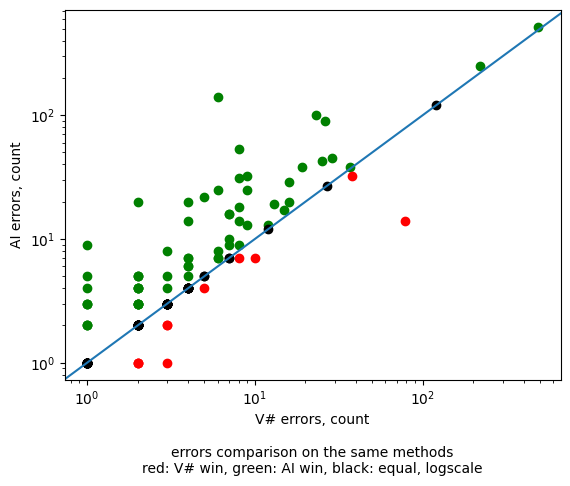

len(AI_more)=27, len(VSharp_more)=81, len(eq)=82


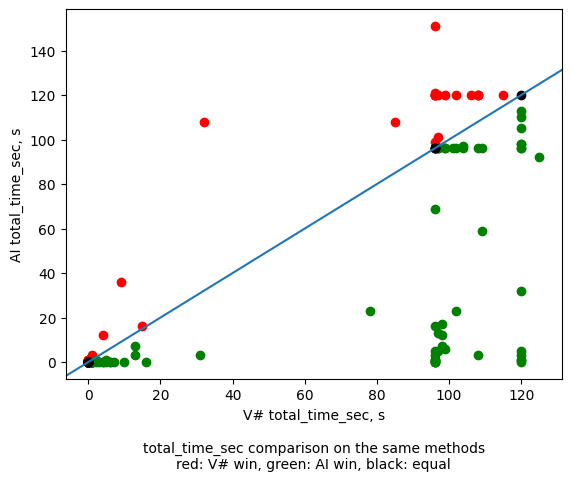

In [13]:
compare(
    dataframe=inner_df,
    on="coverage",
    desc="red: V# win, green: AI win, black: equal",
    metric="%",
    divider_line=True,
)
compare(
    dataframe=inner_df,
    on="tests",
    desc="red: V# win, green: AI win, black: equal",
    metric="count",
    divider_line=True,
    reverse_colors=True,
    logscale=True,
)
compare(
    dataframe=inner_df,
    on="errors",
    desc="red: V# win, green: AI win, black: equal",
    metric="count",
    divider_line=True,
    logscale=True,
)
compare(
    dataframe=inner_df,
    on="total_time_sec",
    desc="red: V# win, green: AI win, black: equal",
    metric="s",
    divider_line=True,
    reverse_colors=True,
)

In [14]:
inner_hundred = inner_df.loc[inner_df["coverageAI"] == inner_df["coverageV#"]]
# inner_hundred = inner_hundred.loc[inner_hundred["coverageV#"] == 100]
inner_hundred

,method,testsV#,errorsV#,coverageV#,total_time_secV#,timeoutedV#,testsAI,errorsAI,coverageAI,total_time_secAI,timeoutedAI
0,BinarySearch,7,0,100.0,0,False,7,1,100.0,0,False
1,Switches1,31,0,100.0,31,False,30,0,100.0,3,False
2,Switches2,10,0,100.0,104,False,12,0,100.0,97,False
4,Switches4,10,3,100.0,96,False,12,3,100.0,0,False
5,Switches5,5,3,100.0,1,False,5,5,100.0,0,False
...,...,...,...,...,...,...,...,...,...,...,...
176,ContainerParentJob.ResumeJob,1,2,2.0,108,False,0,2,2.0,120,True
177,ContainerParentJob.StartJob,1,2,2.0,108,False,0,2,2.0,120,True
178,ShaderStringBuilder.AppendLines,2,4,62.0,96,False,2,7,62.0,151,True
183,HlslTokenizer.Init,3,4,35.0,102,False,2,4,35.0,96,False


len(AI_more)=19, len(VSharp_more)=10, len(eq)=103


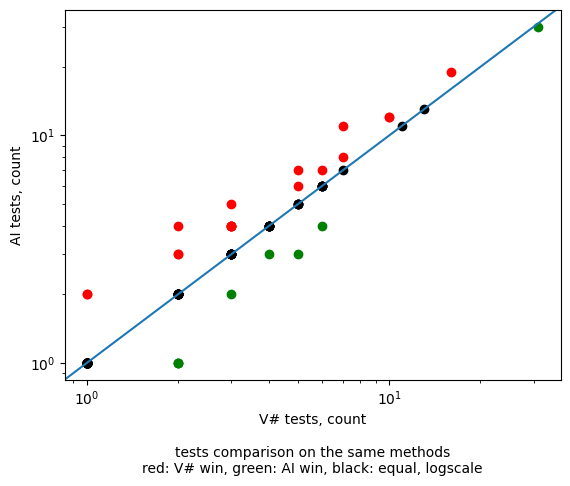

len(AI_more)=33, len(VSharp_more)=9, len(eq)=90


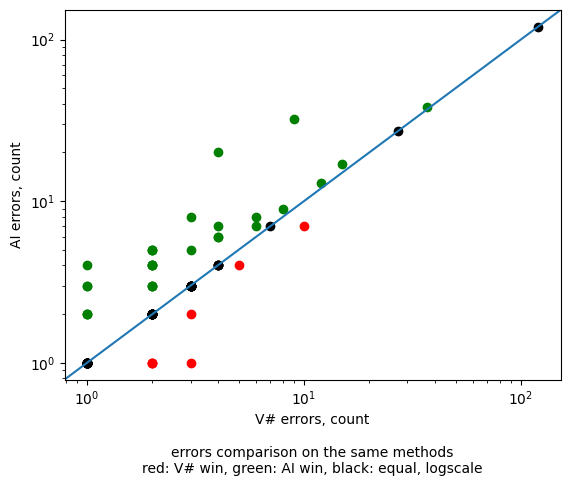

len(AI_more)=12, len(VSharp_more)=42, len(eq)=78


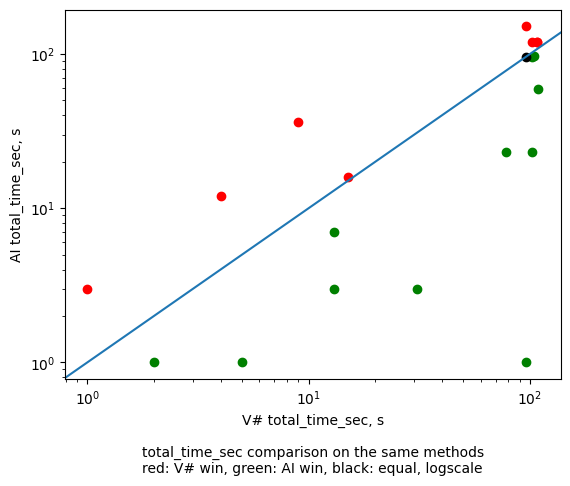

In [15]:
compare(
    dataframe=inner_hundred,
    on="tests",
    desc="red: V# win, green: AI win, black: equal",
    metric="count",
    divider_line=True,
    reverse_colors=True,
    logscale=True,
)
compare(
    dataframe=inner_hundred,
    on="errors",
    desc="red: V# win, green: AI win, black: equal",
    metric="count",
    divider_line=True,
    logscale=True,
)
compare(
    dataframe=inner_hundred,
    on="total_time_sec",
    desc="red: V# win, green: AI win, black: equal",
    metric="s",
    divider_line=True,
    reverse_colors=True,
    logscale=True,
)